### License Plate Detection

### Load Dataset

In [1]:
import math
import os
from dotenv import load_dotenv, find_dotenv

import matplotlib.pyplot as plt
import numpy as np
import cv2

load_dotenv(find_dotenv(), override=True)
api_key = os.getenv("api_key")


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("yolotraining-dfaoh").project("ocr-nsde5")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Load Model

In [2]:
from super_gradients.training import models

device="cpu"

model = models.get("yolo_nas_s",
                        num_classes=1,
                        checkpoint_path='./Checkpoints/ckpt_best.pth').to(device)

[2023-08-06 00:27:01] INFO - utils.py - Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-08-06 00:27:01] INFO - utils.py - NumExpr defaulting to 8 threads.


### Load image for prediction

User provided device_type of 'cuda', but CUDA is not available. Disabling


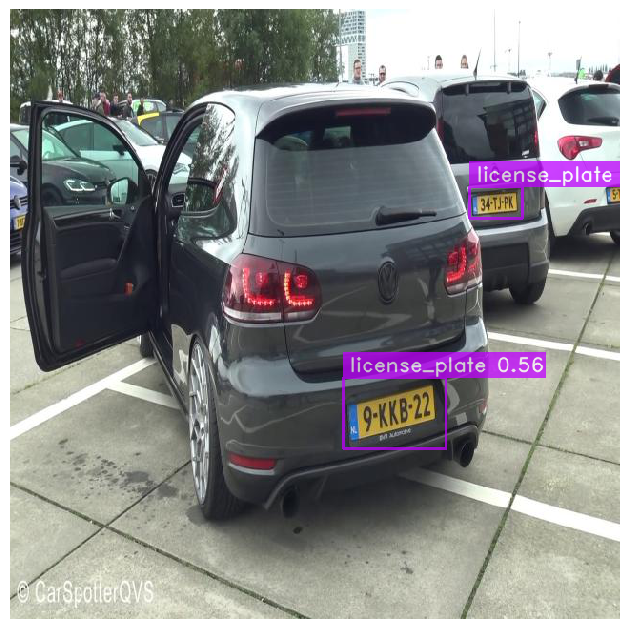

In [24]:
img_url = "OCR-2/valid/images/264_jpg.rf.2356f7b75e6c791b2d2be2905df1490a.jpg"
model.predict(img_url).show()


### License Plate Detection

In [22]:
def object_detection(image, confidence):
    device = "cpu"
    model = models.get('yolo_nas_s', 
                        num_classes=1, 
                        checkpoint_path='./Checkpoints/ckpt_best.pth').to(device)
    class_names = ['license-plate']

    result = list(model.predict(image, conf=confidence))[0]
    bbox_xyxys = result.prediction.bboxes_xyxy.tolist()
    confidence = result.prediction.confidence
    labels = result.prediction.labels.tolist()
    
    for (bbox_xyxy, confidence, cls) in zip(bbox_xyxys, confidence, labels):
        bbox = np.array(bbox_xyxy)
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        classname = int(cls)
        class_name = class_names[classname]
        conf = math.ceil(confidence*100)/100
        label = f"{class_name}{conf}"
        print(x1, y1, x2, y2)
        text_size = cv2.getTextSize(label, 0, fontScale=1, thickness=2)[0]
        background = x1 + text_size[0], y1 - text_size[1] - 3       
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 255), 3)
        cv2.rectangle(image, (x1, y1), background, [255, 144, 20], -1, cv2.LINE_AA)
        cv2.putText(image, label, (x1, y1-2), 0, 1, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)
    
    resize_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis scale and ticks
    plt.show()

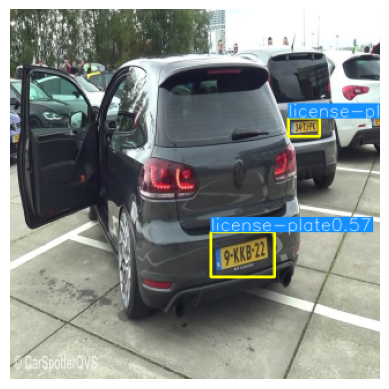

: 

In [27]:
image = cv2.imread(img_url)
object_detection(image, 0.45)

### License Plate Deection on video

In [5]:
def object_detction_video(video, confidence):
    cap = cv2.VideoCapture(video)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    
    device = "cpu"
    model = models.get('yolo_nas_s', 
                        num_classes=1, 
                        checkpoint_path='./Checkpoints/ckpt_best.pth').to(device)
    class_names = ['license-plate']
    output = cv2.VideoWriter('./Videos/detections.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if ret:
            result = list(model.predict(frame, conf=0.45))[0]
            bbox_xyxys = result.prediction.bboxes_xyxy.tolist()
            confidences = result.prediction.confidence
            labels = result.prediction.labels.tolist()
            for (bbox_xyxy, confidence, cls) in zip(bbox_xyxys, confidences, labels):
                bbox = np.array(bbox_xyxy)
                x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                classname = int(cls)
                class_name = class_names[classname]
                conf = math.ceil((confidence*100))/100
                label = f'{class_name}{conf}'
                print(x1, y1,x2, y2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), [255,144, 30], 3)
                t_size = cv2.getTextSize(label, 0, fontScale = 1, thickness=2)[0]
                c2 = x1 + t_size[0], y1 - t_size[1] -3
                cv2.rectangle(frame, (x1, y1), c2, [255,144, 30], -1, cv2.LINE_AA)
                cv2.putText(frame, label, (x1, y1-2), 0, 1, [255, 255, 255], thickness=1, lineType = cv2.LINE_AA)
            cv2.imshow("Frame", frame)
            if cv2.waitKey(1) & 0xFF == ord('1'):
                break
        else:
            break

    output.release()
    cv2.destroyAllWindows()


In [9]:
video = "./Videos/demo.mp4"
object_detction_video(video, 0.35)

: 